## Final analysis of all training conditions (220512)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy.stats as stats

from helpers import catch, multi_load_logs_as_df, annotate, weight_map, metric_names, reduce_df, ceilings, condition_names, add_r_and_p

In [3]:
# make the SVG figures pliable
import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
plt.rcParams['svg.fonttype'] = 'none'

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
logdir = '../../final_results/final_logs/'
event_paths = [y for x in os.walk(logdir) for y in glob.glob(os.path.join(x[0], 'events*'))]

df = multi_load_logs_as_df(event_paths)
df['weight_path'] = df['path'].apply(lambda x: x.replace(logdir, '').split('events')[0])
df['version'] = df['path'].apply(lambda x : x.split('version_')[1].split('/')[0])
df['fit'] = df['loss_weights'].apply(weight_map)
df['cond'] = df['path'].apply(lambda x:x.split('/')[4])

# simplifed condition, remove mix_ratio
df['condition'] = df['cond'].apply(lambda x : x.split('-final-')[1].split('-mix')[0])
df['condition'] = df['condition'].apply(lambda x : condition_names[x])
df['Loss'] = df['condition']

# the mixing rate of neural gradiants -- 0 means none, 1 means even mix of label and neural gradiants
# df['mix_ratio'] = df['cond'].apply(lambda x: np.float(catch(x, 'mix')))
df['mix_ratio'] = df['cond'].apply(lambda x: mix_ratio_map(catch(x, 'mix')))
df['labels'] = df['cond'].apply(lambda x: catch(x, 'labels'))
df['controls'] = df['controls'].str.strip('"[]').str.strip("'")

In [5]:
def mix_ratio_map(mix_ratio):
    ratio_map = {
        '0' : '0:100', 
        '0.03125' : '3:100',
        '0.0625' : '6:100',
        '0.125' : '12:100', 
        '0.25' : '25:100', 
        '0.5' : '50:100',  
        '1' : '100:100', 
    }
    return ratio_map[mix_ratio]


In [7]:
groupby_cols = [
    'metric', 'seed', 'fit', 
    'loss_weights', 'cond', 'condition', 'Loss',
    'mix_ratio', 'neural_loss', 'controls',
    'weight_path'
]
df.groupby(groupby_cols).count().head()

value  \
metric         seed fit            loss_weights    cond                              condition Loss mix_ratio neural_loss controls weight_path                                                 
CKA_bento.coco 1.0  ImageNet, IT,  [1.0, 1.0, 0.0] 220505-final-labels_0-mix_0       IT        IT   0:100     logCKA      None     220505-final-labels_0-mix_0/model_cornet_s-loss...     41   
                                                   220505-final-labels_0-mix_0.03125 IT        IT   3:100     logCKA      None     220505-final-labels_0-mix_0.03125/model_cornet_...     41   
                                                   220505-final-labels_0-mix_0.0625  IT        IT   6:100     logCKA      None     220505-final-labels_0-mix_0.0625/model_cornet_s...     41   
                                                   220505-final-labels_0-mix_0.125   IT        IT   12:100    logCKA      None     220505-final-labels_0-mix_0.125/model_cornet_s-...     41   
                                                   220505-final-labels_0-mix_0.25    IT        IT   25:100    logCKA      None     220505-final-labels_0-mix_0.25/model_cornet_s-l...     41   

                                                                                                                                                                                       step  \
metric         seed fit            loss_weights    cond                              condition Loss mix_ratio neural_loss controls weight_path                                                
CKA_bento.coco 1.0  ImageNet, IT,  [1.0, 1.0, 0.0] 220505-final-labels_0-mix_0       IT        IT   0:100     logCKA      None     220505-final-labels_0-mix_0/model_cornet_s-loss...    41   
                                                   220505-final-labels_0-mix_0.03125 IT        IT   3:100     logCKA      None     220505-final-labels_0-mix_0.03125/model_cornet_...    41   
                                                   220505-final-labels_0-mix_0.0625  IT        IT   6:100     logCKA      None     220505-final-labels_0-mix_0.0625/model_cornet_s...    41   
                                                   220505-final-labels_0-mix_0.125   IT        IT   12:100    logCKA      None     220505-final-labels_0-mix_0.125/model_cornet_s-...    41   
                                                   220505-final-labels_0-mix_0.25    IT        IT   25:100    logCKA      None     220505-final-labels_0-mix_0.25/model_cornet_s-l...    41   

                                                                                                                                                                                       adv_eval_neural  \
metric         seed fit            loss_weights    cond                              condition Loss mix_ratio neural_loss controls weight_path                                                           
CKA_bento.coco 1.0  ImageNet, IT,  [1.0, 1.0, 0.0] 220505-final-labels_0-mix_0       IT        IT   0:100     logCKA      None     220505-final-labels_0-mix_0/model_cornet_s-loss...               41   
                                                   220505-final-labels_0-mix_0.03125 IT        IT   3:100     logCKA      None     220505-final-labels_0-mix_0.03125/model_cornet_...               41   
                                                   220505-final-labels_0-mix_0.0625  IT        IT   6:100     logCKA      None     220505-final-labels_0-mix_0.0625/model_cornet_s...               41   
                                                   220505-final-labels_0-mix_0.125   IT        IT   12:100    logCKA      None     220505-final-labels_0-mix_0.125/model_cornet_s-...               41   
                                                   220505-final-labels_0-mix_0.25    IT        IT   25:100    logCKA      None     220505-final-labels_0-mix_0.25/model_cornet_s-l...               41   

                                                                                     

In [8]:
df_ = df.groupby(groupby_cols).filter(lambda x:len(x) in [41])
data = df_.groupby(groupby_cols).apply(
    lambda x:x.pivot(index='step', columns='metric', values='value')
).reset_index()
data['CKA_fneurons.ustimuli'] = 1-data['CKA_fneurons.ustimuli']
data['CKA_magneto.var6'] = 1-data['CKA_magneto.var6']
data['CKA_nano.var6'] = 1-data['CKA_nano.var6']
data['CKA_magneto.var6_ceiled'] = data['CKA_magneto.var6'] / ceilings['CKA_magneto.var6']
data['CKA_nano.var6_ceiled'] = data['CKA_nano.var6'] / ceilings['CKA_nano.var6']
data['CKA_nano.left.var6'] = 1-data['CKA_nano.left.var6']
data['CKA_nano.coco'] = 1-data['CKA_nano.coco'] 
data['CKA_bento.coco'] = 1-data['CKA_bento.coco'] 
data['CKA_nano.coco_ceiled'] = data['CKA_nano.coco'] / ceilings['CKA_nano.coco']
data['CKA_bento.coco_ceiled'] = data['CKA_bento.coco'] / ceilings['CKA_bento.coco']
data['seed'] = data['seed'].astype(int)
data['fit'] = data['loss_weights'].apply(weight_map)
data['labels'] = data['loss_weights'].apply(lambda x:eval(x)[-1]==1)

# merges all the metrics to the same row instead of having them long form.
data = reduce_df(data)

# and compute averaged metric scores
data['averaged_ceiled_CKA'] = np.mean([
    data[metric].values
    for metric in 
    ['CKA_magneto.var6_ceiled',
     'CKA_nano.var6_ceiled', 
     'CKA_nano.coco_ceiled',
     'CKA_bento.coco_ceiled']
], axis=0)

data['averaged_ceiled_CKA_HVM'] = np.mean([
    data[metric].values
    for metric in 
    ['CKA_magneto.var6_ceiled',
     'CKA_nano.var6_ceiled']
], axis=0)

data['averaged_ceiled_CKA_COCO'] = np.mean([
    data[metric].values
    for metric in 
    ['CKA_nano.coco_ceiled',
     'CKA_bento.coco_ceiled']
], axis=0)

data['normalized_adv_val'] = data['ImageNet_adv_val_acc1']/data['ImageNet_val_acc1']
data.to_csv('final_model_results.csv')

In [9]:
sns.set(rc={'figure.figsize':(15.7,10.27), "font.size":22,})
sns.set_context('paper')
sns.set_style("white")
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

# show by step

In [ ]:
metrics = [
#     'CKA_fneurons.ustimuli',
#     'CKA_magneto.var6_ceiled',
#     'CKA_nano.var6_ceiled',
#     'CKA_nano.coco_ceiled',
#     'CKA_bento.coco_ceiled',
#     'ImageNet_val_acc1',
#     'ImageNet_adv_val_acc1',
    'Stimuli_fneurons.ustimuli_val_acc1',
    'Stimuli_fneurons.ustimuli_adv_val_acc1',
#     'Stimuli_magneto.var6_val_acc1',
#     'Stimuli_magneto.var6_adv_val_acc1',
#     'Stimuli_bento.coco_val_acc1',
#     'Stimuli_bento.coco_adv_val_acc1',
#     'dicarlo.Kar2018-i2n',
#     'dicarlo.Kar2022human-i2n',
#     'dicarlo.Rajalingham2018-i2n',
#     'dicarlo.Rajalingham2018subset-i2n',
#     'dicarlo.Kar2018-i2n_acc',
#     'dicarlo.Kar2022human-i2n_acc',
#     'dicarlo.Rajalingham2018-i2n_acc',
#     'dicarlo.Rajalingham2018subset-i2n_acc',
]


# data_ = data[
#     (data['neural_loss'].isin(['logCKA']))
#     &(data['labels'])
#     &(data['step']>1900)
# ]
data_ = data

for metric in metrics:
    ax = sns.relplot(x='step', y=metric, hue='mix_ratio', col='condition', #style='fit',
                     aspect=1.2, kind='line', data=data_)
    ax.set_ylabels(metric_names[metric])
    ax.set_xlabels('Gradient Steps')
    plt.axvline(x=1950, linestyle='--')
    plt.show()

## Figure 1: average neural sim vs average behavior / adv robustness

In [ ]:
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
condition_order = np.array([val for key, val in condition_names.items()])
pal = np.array(sns.color_palette("Paired"))[[0,1,2,3,6,7,8,9]]

In [16]:
# and compute averaged metric scores
adv_metrics = [
    'Stimuli_magneto.var6_adv_val_acc1',
    'Stimuli_bento.coco_adv_val_acc1',
]

data['adv_accuracy'] = np.mean([
    data[metric].values
    for metric in 
    adv_metrics
], axis=0)

behavior_metrics = [
    'dicarlo.Kar2022human-i2n',
    'dicarlo.Kar2018-i2n',
]

data['behavior_i2n'] = np.mean([
    data[metric].values
    for metric in 
    behavior_metrics
], axis=0)

In [17]:
data['condition'].unique()

array(['IT', 'Random IT', 'Shuffled IT', 'IT + Adv Classification',
       'IT + Classification', 'Random IT + Classification',
       'Shuffled IT + Classification', 'Adv Classification'], dtype=object)

In [18]:
data_ = pd.concat([
    data[
        (data['step']==26399) # last step
        &(data['condition'].isin(['IT + Classification']))
    ]
])

start = data_[data_['step']==1979]['averaged_ceiled_CKA'].mean() # last step before IT grads kick in

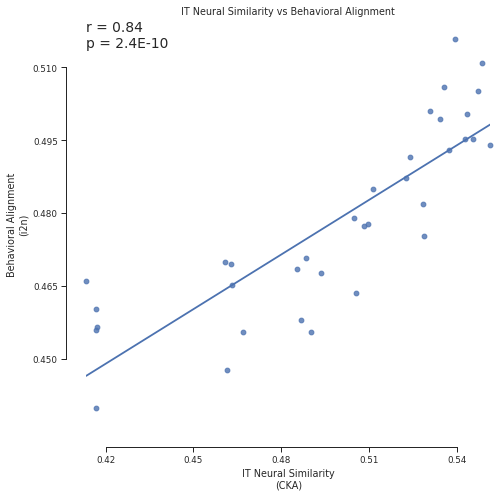

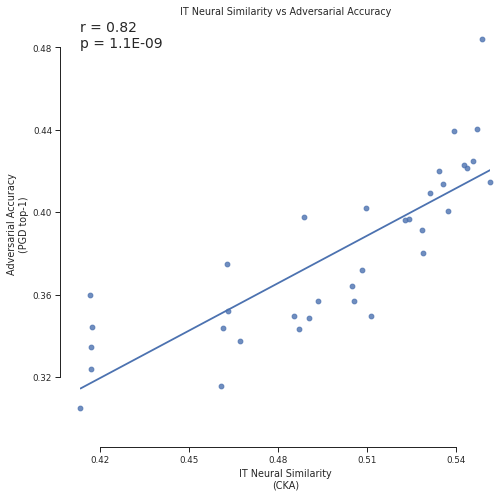

In [26]:
X = 'averaged_ceiled_CKA'

avg_metrics = [
    'behavior_i2n',
    'adv_accuracy',
]

for metric in avg_metrics:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
    ax = sns.regplot(
        x=X, y=metric, 
        data=data_, ax=ax,
        ci=None,
        scatter_kws={
            'clip_on': False,
        },
        
    )

    ax.set_ylabel(metric_names[metric])
    ax.set_xlabel(metric_names[X])
    ax.yaxis.set_major_locator(MaxNLocator(6)) 
    ax.xaxis.set_major_locator(MaxNLocator(5)) 
    sns.despine(offset=20, trim=True)
    
    
    add_r_and_p(data_, metric, X, ax)
    X_name = metric_names[X].split('\n')[0]
    Y_name = metric_names[metric].split('\n')[0]
    title = f'{X_name} vs {Y_name}'
    ax.set_title(title)
    
    plt.tight_layout()
    plt.savefig(f'{title}.svg', format='svg')

## Figure 2: validating improved neural similarity

In [53]:
data_['mix_ratio'].unique()

array(['0:100', '3:100', '6:100', '12:100', '25:100', '50:100', '100:100'],
      dtype=object)

[(0.16342174, 0.0851396, 0.21088893),
 (0.33067031, 0.11701189, 0.30632563),
 (0.51728314, 0.1179558, 0.35453252),
 (0.70457834, 0.0882129, 0.34473046),
 (0.86641628, 0.17387796, 0.27070818),
 (0.94291042, 0.37549479, 0.26369821),
 (0.96173392, 0.57988594, 0.41844491),
 (0.96656022, 0.75658231, 0.62527295)]

array(['#8DE5A1', '#FF9F9B'], dtype='<U7')

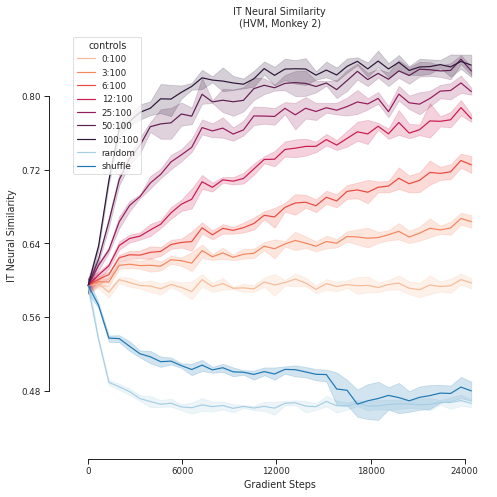

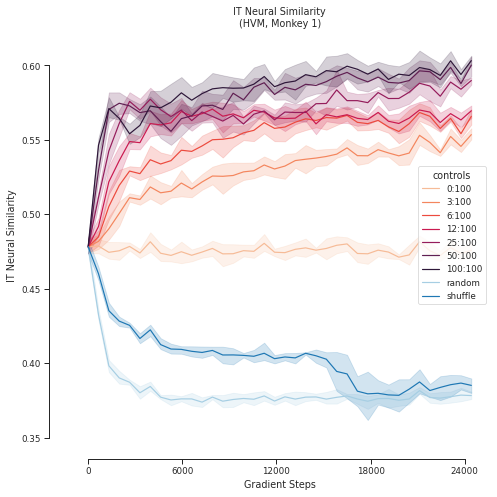

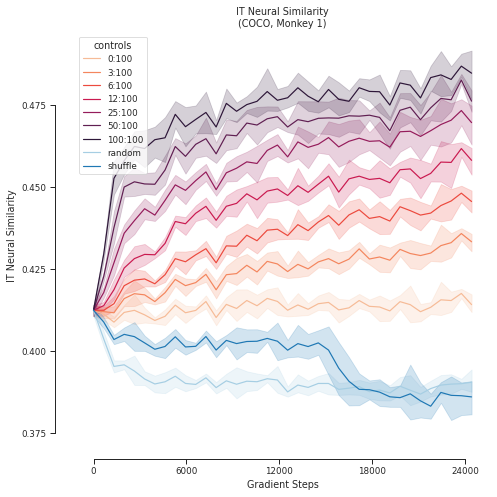

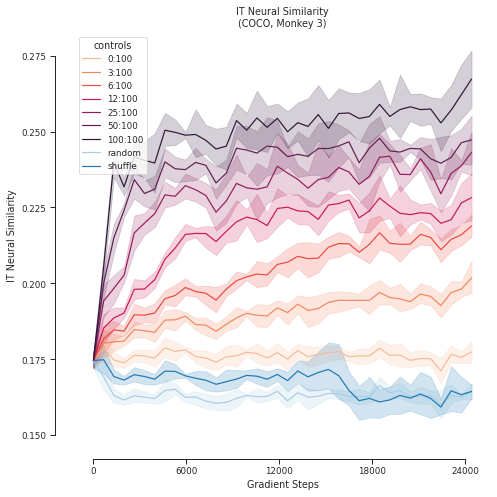

In [74]:
metrics = [
    'CKA_magneto.var6_ceiled',
    'CKA_nano.var6_ceiled',
    'CKA_nano.coco_ceiled',
    'CKA_bento.coco_ceiled'
]

treatments = [
    'IT + Classification'
]

controls = [
    'Random IT + Classification',
    'Shuffled IT + Classification'
]

for metric in metrics:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
    
    # 1979 is last measurement before IT grads kick in
    data_ = data[
        (data['condition'].isin(treatments))
        &(data['step']>1900)
    ].copy()
    data_['step'] = data_['step'] - 1979
    
    ax = sns.lineplot(
        x='step', y=metric, 
        hue='mix_ratio', data=data_,
        palette=sns.color_palette("rocket_r", 7),
        ax=ax
    )
    
    data_ = data[
        (data['condition'].isin(controls))
        &(data['step']>1900)
    ].copy()
    data_['step'] = data_['step'] - 1979
    
    ax = sns.lineplot(
        x='step', y=metric, 
        hue='controls', data=data_,
        palette=sns.color_palette("Paired",2),
        ax=ax,
    )
    
    ax.yaxis.set_major_locator(MaxNLocator(6)) 
    ax.xaxis.set_major_locator(MaxNLocator(5)) 
  
    sns.despine(offset=20, trim=True)
#     sns.despine()
    title = f'{metric_names[metric]}'
    ax.set_title(title)
    ax.set_ylabel(metric_names[metric].split('\n')[0])
    ax.set_xlabel('Gradient Steps')
    plt.tight_layout()
    plt.savefig(f'{title}.svg', format='svg')
    plt.show()

## Figure 3 and 4: All vs All HVM and COCO behavior and PGD accuracy

In [75]:
groupby_cols = [
    'seed',
    'fit',
    'loss_weights',
    'cond',
    'mix_ratio',
    'neural_loss'
]

In [76]:
metric_sets = [
    ('dicarlo.Kar2022human-i2n_acc', ('Stimuli_magneto.var6_adv_val_acc1', 'dicarlo.Kar2022human-i2n')),
    ('dicarlo.Kar2018-i2n_acc', ('Stimuli_bento.coco_adv_val_acc1', 'dicarlo.Kar2018-i2n')),
    ('dicarlo.Rajalingham2018-i2n_acc', ('dicarlo.Rajalingham2018-i2n', 'dicarlo.Rajalingham2018-i2n')),
    ('dicarlo.Rajalingham2018subset-i2n_acc', ('dicarlo.Rajalingham2018subset-i2n', 'dicarlo.Rajalingham2018subset-i2n')),
]

In [16]:
df['condition'].unique()

array(['IT', 'IT + Adv Classification', 'IT + Classification',
       'Random IT', 'Adv Classification', 'Shuffled IT + Classification',
       'Shuffled IT', 'Random IT + Classification'], dtype=object)

/home/joeldapello/anaconda3/envs/braintree-0.2/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/home/joeldapello/anaconda3/envs/braintree-0.2/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/home/joeldapello/anaconda3/envs/braintree-0.2/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/home/joeldapello/anaconda3/envs/braintree-0.2/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in

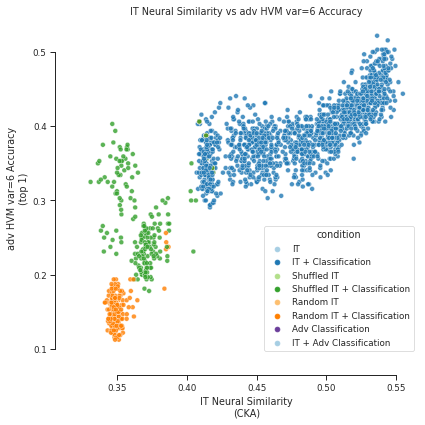

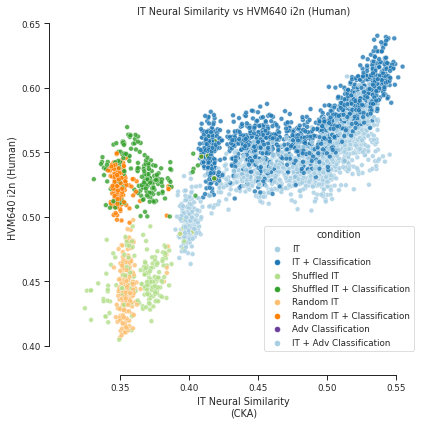

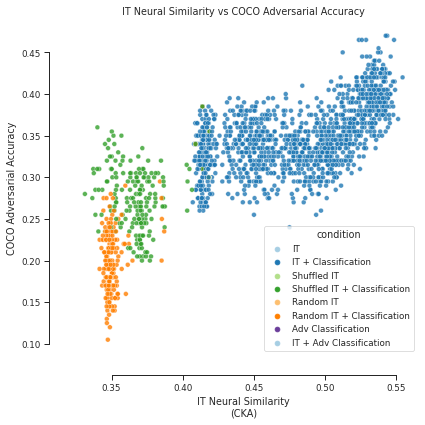

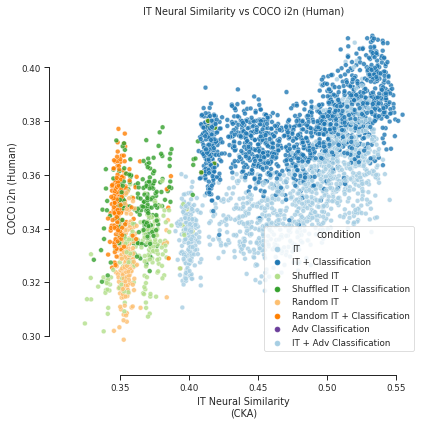

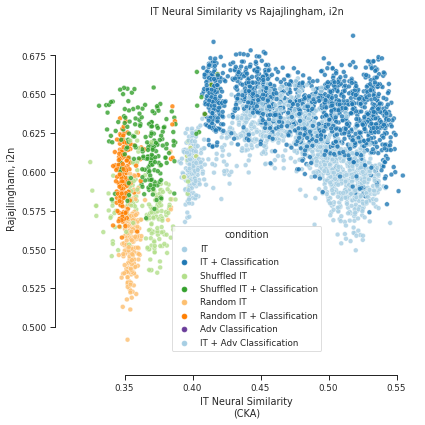

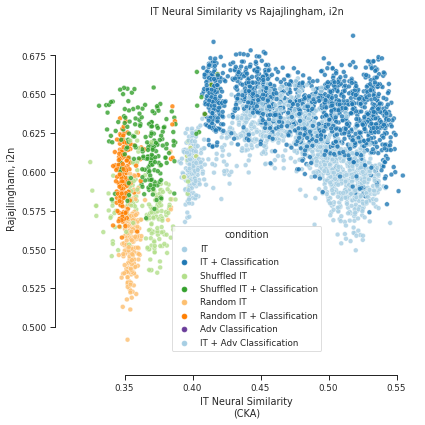

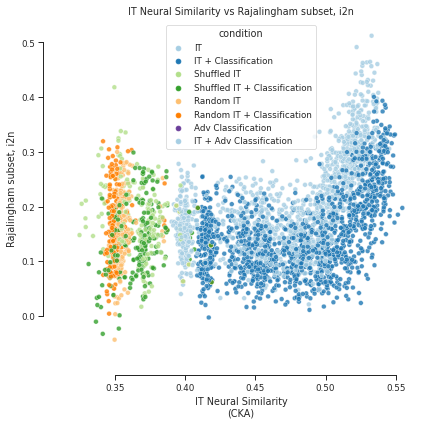

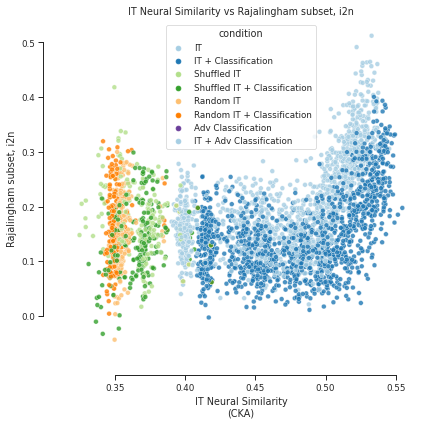

In [17]:
# filter samples that have lost more than 2% accuracy (from a retrained linear readout)

show_all = [
    'IT', 
    'IT + Classification',
    'Random IT', 
    'Random IT + Classification',
    'Shuffled IT', 
    'Shuffled IT + Classification',
]

for metric_set in metric_sets:
    metric, plot_metrics = metric_set

    data_ = pd.concat([
        data[
            (data['step']>1970)
            &(data['neural_loss'].isin(['logCKA']))
        ]
    ])
    
    # filter samples that have lost more than thresholded accuracy
    data_[metric+'_ref'] = data_.groupby(groupby_cols)[metric].transform('first')
    data_['Clean accuracy loss'] = data_[metric] - data_[metric+'_ref']
    data_.loc[data_['Clean accuracy loss']>0, 'Clean accuracy loss'] = 0
    
    # calculate starting point
    start = data_[
        (data_['step']==1979)
        &(data_['condition']=='IT + Classification Loss')
    ]['averaged_ceiled_CKA'].mean()

    X = 'averaged_ceiled_CKA'

    for plot_metric in plot_metrics:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

        data__ = data_[
            (data_['condition'].isin(show_all))
        ]
    
        ax = sns.scatterplot(
            hue='condition',
            hue_order=condition_order,
            palette=pal,
            x=X, y=plot_metric, 
            data=data__, ax=ax,
            alpha=0.8,
            clip_on=False
        )
        
        ax.set_ylabel(metric_names[plot_metric])
        ax.set_xlabel(metric_names[X])
        sns.despine(offset=20, trim=True)

        plt.axvline(x=start, linestyle='--')
        X_name = metric_names[X].split('\n')[0]
        Y_name = metric_names[plot_metric].split('\n')[0]
        title = f'{X_name} vs {Y_name}'
        ax.set_title(title)
#         ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


        plt.tight_layout()
        plt.savefig(f'{title}.svg', format='svg')

### draft

In [18]:
def smooth_xy_avg(data, x_metric, y_metric, ax, width=700, sample_every=5):
    xs = []
    ys = []
    
    for i in range(0, len(data)-width, sample_every):
        df = data.sort_values(by=[x_metric]).reset_index()[i:i+width].copy()
        xs.append(df[x_metric].mean())
        ys.append(df[y_metric].mean())
    xs = np.array(xs)
    ys = np.array(ys)
    
    ax = sns.lineplot(
        x=xs, y=ys, ax=ax,
        linewidth = 7,
#         color='blue'
    )
    return ax

def mark_baseline(data, x_metric, y_metric, ax):
    mark_x = data[
        (data['condition']=='IT + Classification')
        &(data['mix_ratio']==0)
    ][X].mean()

    mark_y = data[
        (data['condition']=='IT + Classification')
        &(data['mix_ratio']==0)
    ][plot_metric].mean()
    
    ax = sns.scatterplot(x=[mark_x], y=[mark_y], s=100, ax=ax)
    return ax

In [26]:
metric_sets = [
    ('dicarlo.Kar2022human-i2n_acc', ('Stimuli_magneto.var6_adv_val_acc1', 'dicarlo.Kar2022human-i2n')),
    ('dicarlo.Kar2018-i2n_acc', ('Stimuli_bento.coco_adv_val_acc1', 'dicarlo.Kar2018-i2n')),
    ('dicarlo.Rajalingham2018-i2n_acc', ('dicarlo.Rajalingham2018-i2n', 'dicarlo.Rajalingham2018-i2n', 'dicarlo.Rajalingham2018-i2n_acc')),
    ('dicarlo.Rajalingham2018subset-i2n_acc', ('dicarlo.Rajalingham2018subset-i2n', 'dicarlo.Rajalingham2018subset-i2n', 'dicarlo.Rajalingham2018subset-i2n_acc')),

]

/home/joeldapello/anaconda3/envs/braintree-0.2/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/home/joeldapello/anaconda3/envs/braintree-0.2/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/home/joeldapello/anaconda3/envs/braintree-0.2/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/home/joeldapello/anaconda3/envs/braintree-0.2/lib/python3.7/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in

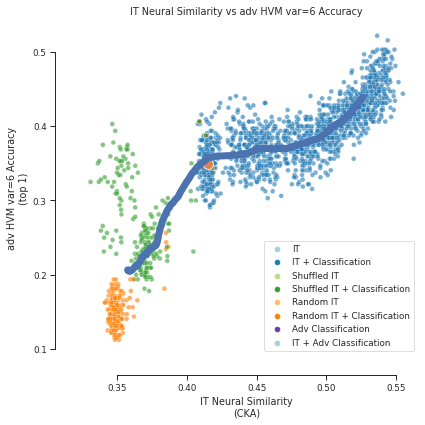

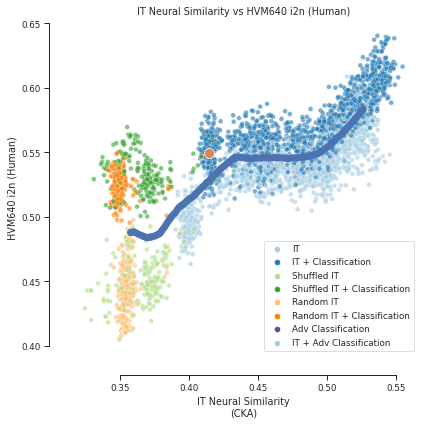

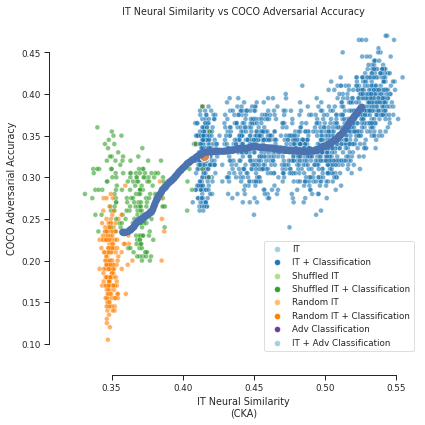

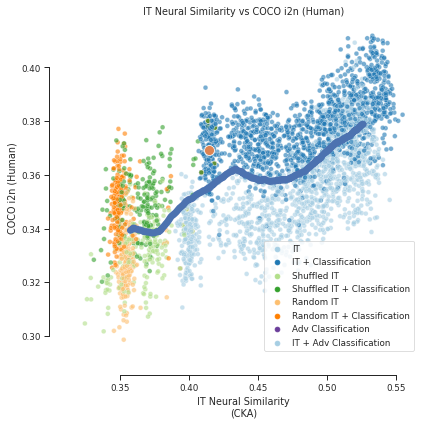

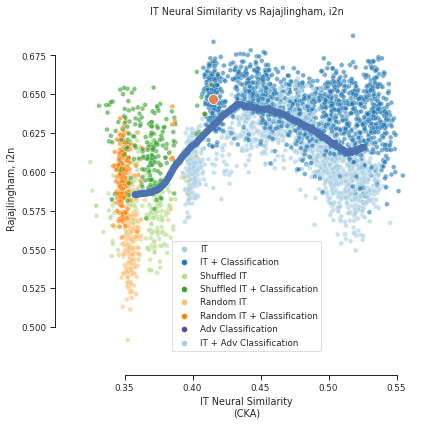

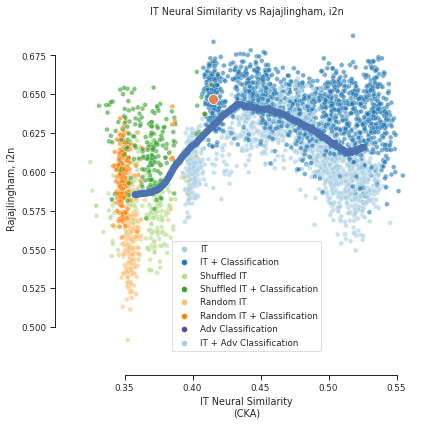

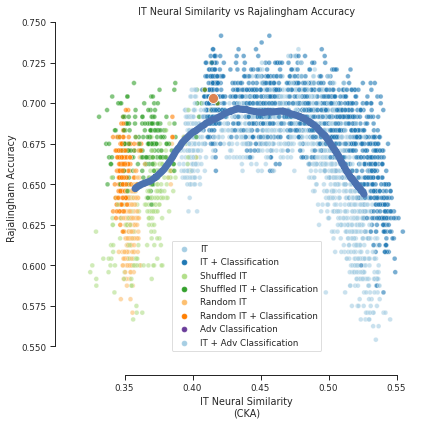

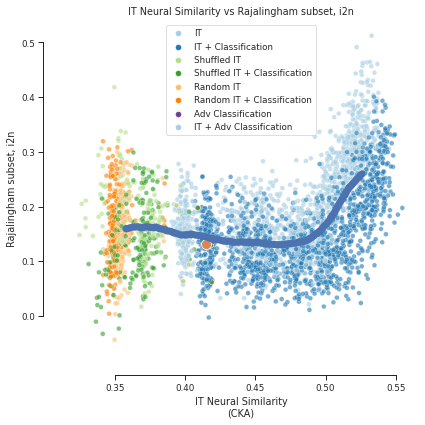

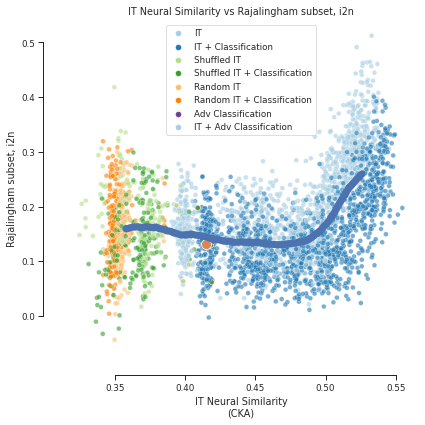

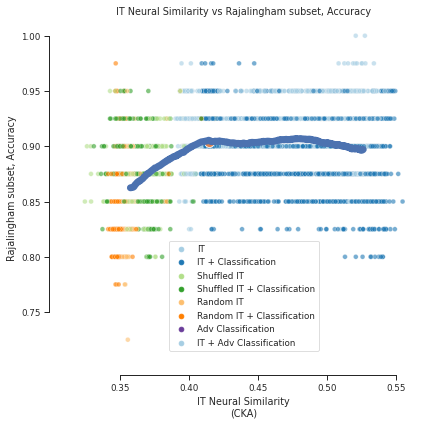

In [27]:
show_all = [
    'IT', 
    'IT + Classification',
    'Random IT', 
    'Random IT + Classification',
    'Shuffled IT', 
    'Shuffled IT + Classification',
]

for metric_set in metric_sets:
    metric, plot_metrics = metric_set

    data_ = pd.concat([
        data[
            (data['step']>1970)
            &(data['neural_loss'].isin(['logCKA']))
        ]
    ])
    
    # filter samples that have lost more than thresholded accuracy
    data_[metric+'_ref'] = data_.groupby(groupby_cols)[metric].transform('first')
    data_['Clean accuracy loss'] = data_[metric] - data_[metric+'_ref']
    data_.loc[data_['Clean accuracy loss']>0, 'Clean accuracy loss'] = 0
    
    # calculate base model mean
    start = data_[
        (data_['step']==1979)
        &(data_['condition']=='IT + Classification Loss')
    ]['averaged_ceiled_CKA'].mean()

    X = 'averaged_ceiled_CKA'

    for plot_metric in plot_metrics:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

        data__ = data_[
            (data_['condition'].isin(show_all))
        ]
    
        ax = sns.scatterplot(
            hue='condition',
            hue_order=condition_order,
            palette=pal,
            x=X, y=plot_metric, 
            data=data__, ax=ax,
            alpha=0.6,
            clip_on=False
        )
        
        ax = smooth_xy_avg(
            data__, x_metric=X, y_metric=plot_metric, ax=ax
        )
        
        ax = mark_baseline(
            data__, x_metric=X, y_metric=plot_metric, ax=ax
        )

        ax.set_ylabel(metric_names[plot_metric])
        ax.set_xlabel(metric_names[X])
        sns.despine(offset=20, trim=True)

        plt.axvline(x=start, linestyle='--')
        X_name = metric_names[X].split('\n')[0]
        Y_name = metric_names[plot_metric].split('\n')[0]
        title = f'{X_name} vs {Y_name}'
        ax.set_title(title)

        plt.tight_layout()
        plt.savefig(f'{title}.svg', format='svg')

### rebuttal data and plots

In [69]:
from scipy.stats import ks_2samp

In [29]:
data['condition'].unique()

array(['IT', 'Random IT', 'Shuffled IT', 'IT + Adv Classification',
       'IT + Classification', 'Random IT + Classification',
       'Shuffled IT + Classification', 'Adv Classification'], dtype=object)

In [27]:
data.columns

Index(['seed', 'fit', 'loss_weights', 'cond', 'condition', 'Loss', 'mix_ratio',
       'neural_loss', 'controls', 'weight_path', 'step', 'CKA_bento.coco',
       'CKA_bento.coco_ceiled', 'labels', 'CKA_fneurons.ustimuli',
       'CKA_magneto.left.var6', 'CKA_magneto.var6', 'CKA_magneto.var6_ceiled',
       'CKA_nano.coco', 'CKA_nano.coco_ceiled', 'CKA_nano.left.var6',
       'CKA_nano.var6', 'CKA_nano.var6_ceiled', 'ImageNet_adv_val_acc1',
       'ImageNet_adv_val_acc5', 'ImageNet_adv_val_loss', 'ImageNet_val_acc1',
       'ImageNet_val_acc5', 'ImageNet_val_loss',
       'Stimuli_bento.coco_adv_val_acc1', 'Stimuli_bento.coco_adv_val_acc5',
       'Stimuli_bento.coco_adv_val_loss', 'Stimuli_bento.coco_val_acc1',
       'Stimuli_bento.coco_val_acc5', 'Stimuli_bento.coco_val_loss',
       'Stimuli_fneurons.ustimuli_adv_val_acc1',
       'Stimuli_fneurons.ustimuli_adv_val_acc5',
       'Stimuli_fneurons.ustimuli_adv_val_loss',
       'Stimuli_fneurons.ustimuli_val_acc1',
       'Stimuli_fn

## maintaining accuracy

In [25]:
control_models = pd.concat([
    data[
        (data['step']==26399) # last step
        &(data['condition'].isin(['IT + Classification']))
        &(data_['mix_ratio']=='0:100')
    ]
])

control_models['Stimuli_fneurons.ustimuli_val_acc1'].mean(), control_models['Stimuli_magneto.left.var6_val_acc1'].std()

(0.959375, 0.02590170859770867)

In [26]:
IT_aligned_models = pd.concat([
    data[
        (data['step']==26399) # last step
        &(data['condition'].isin(['IT + Classification']))
        &(data_['mix_ratio']=='100:100')
    ]
])

IT_aligned_models['Stimuli_fneurons.ustimuli_val_acc1'].mean(), IT_aligned_models['Stimuli_fneurons.ustimuli_val_acc1'].std()

(0.9412499904632569, 0.01472402740535069)

## differences in random IT + classification vs IT + classification for behavioral alignment

In [55]:
metric = 'dicarlo.Kar2018-i2n'
# metric = 'dicarlo.Kar2022human-i2n'

IT_aligned_models = pd.concat([
    data[
        (data['step']==26399) # last step
        &(data['condition'].isin(['IT + Classification']))
        &(data_['mix_ratio']=='100:100')
    ]
])

IT_aligned_models[metric].mean(), IT_aligned_models[metric].std()

(0.3839333713054657, 0.004688648324938252)

In [60]:
metric = 'dicarlo.Kar2018-i2n'
# metric = 'dicarlo.Kar2022human-i2n'

control_models = pd.concat([
    data[
        (data['step']==26399) # last step
        &(data['condition'].isin(['Random IT + Classification']))
#         &(data_['mix_ratio']=='100:100')
    ]
])

control_models[metric].mean(), control_models[metric].std()

(0.3501010537147522, 0.006621895824847285)

In [62]:
ks_2samp(control_models[metric].values, IT_aligned_models[metric].values)

KstestResult(statistic=1.0, pvalue=0.007936507936507936)